# Code for paper Retrival reward for ppo finetuning

paper not writed yet, but i gonna write it in few weeks

author 
[AlexWortega](https://github.com/AlexWortega) 
[My blog](https://t.me/lovedeathtransformers)


Make sure you have 32 or more vram 

In [56]:
!nvidia-smi 

Wed Feb 15 14:40:02 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P0    29W /  70W |  15026MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
%%capture
!pip install datasets
!pip install transfomers
!pip install wandb
!pip install sentence-transformers
!pip install trl

In [ ]:
!wandb login

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [1]:
import torch
import wandb
import time
import os
from tqdm import tqdm
import numpy as np
import pandas as pd


from datasets import load_dataset

from transformers import AutoTokenizer, pipeline
import torch
from tqdm import tqdm
from transformers import pipeline, AutoTokenizer
from datasets import load_dataset

from trl import PPOTrainer, PPOConfig, AutoModelForCausalLMWithValueHead
from trl.core import LengthSampler

# old code, using for init models
config = {
    "model_name": "gpt2",
    
    "steps": 20000,
    "batch_size": 256,
    "forward_batch_size": 16,
    "ppo_epochs": 4,   
    "txt_in_min_len": 2,
    "txt_in_max_len": 8,
    "txt_out_min_len": 4,
    "txt_out_max_len": 16,
    "lr": 1.41e-5,
    "init_kl_coef":0.2,
    "target": 6,
    "horizon":10000,
    "gamma":1,
    "lam":0.95,
    "cliprange": .2,
    "cliprange_value":.2,
    "vf_coef":.1, 
}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pipe_device = 0 if torch.cuda.is_available() else -1

In [2]:

from transformers import AutoModelForCausalLM, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(config['model_name'],padding_side='left')
tokenizer.pad_token = tokenizer.eos_token
gpt2_model = AutoModelForCausalLMWithValueHead.from_pretrained(config['model_name'])

In [3]:
gpt2_model = AutoModelForCausalLMWithValueHead.from_pretrained(config['model_name'])
gpt2_model_ref = AutoModelForCausalLMWithValueHead.from_pretrained(config['model_name'])

In [4]:
gpt2_model.to(device)
gpt2_model_ref.to(device)
None

# About data
 - I using cos_e data, its contains a QA pairs with extractive explanation, so its looks like:
 - Its close to common sense reasoning tasks, and also could be solved in ZS style with bigger models
___
Question: When you drive and see someone walking across the street what do we do?
Answer: see someone walking
___


In [5]:
from datasets import load_dataset

dataset = load_dataset("cos_e",'v1.0')
qs = dataset['train']['question']
ans = dataset['train']['abstractive_explanation']

  0%|          | 0/2 [00:00<?, ?it/s]

In [6]:
import pandas as pd


data_qa = []
for question, answer in zip(qs ,ans):
    data_qa+=[f"Question: {question} Answer: {answer} <|endoftext|>"]

In [7]:
print(data_qa[0])

Question: If a lantern is not for sale, where is it likely to be? Answer: a house is the only place that is not likely to sell things <|endoftext|>


# Retrival reward
- A core idea is: what if we gonna use cosine score to measure how close our answer to ground true answer
### Formula
 \begin{align}
reward = cosinesimilarity(GeneratedAnswer, TroundTrueAnswer)
 \end{align}
### A little about hardcode
also, ppo hacking reward when answers question by question, so i add a checks 

Some rewards graphic, std rases because i reward=2 if score >0.7

[link to wandb project](https://wandb.ai/alexwortega/trl/runs/cszh2ve8?workspace=user-alexwortega)

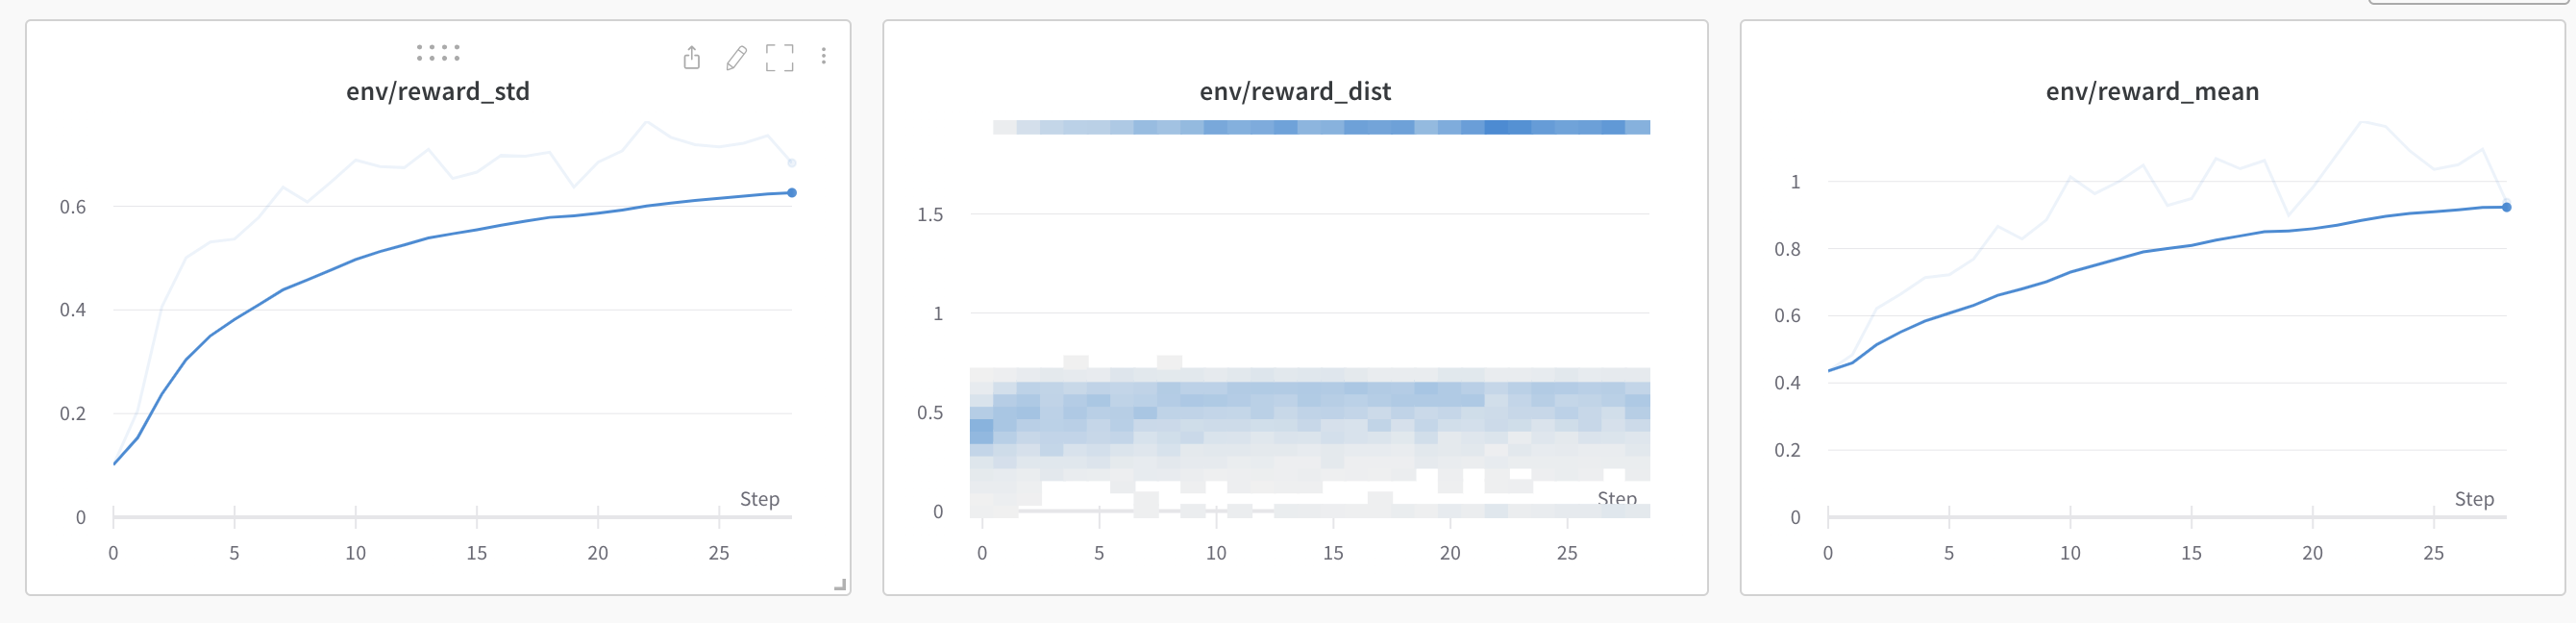

In [8]:

from sentence_transformers import SentenceTransformer, util
import torch

embedder = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')


In [9]:
corpus_embeddings = embedder.encode(data_qa, convert_to_tensor=True)

In [10]:

import numpy as np

def _ans(text):
    """
    - returns a closest questions - answer pairs to prompted
    """
    queries = [text.split('answer')[0]]

    ans =[]
    
    top_k = 5
    for query in queries:
        query_embedding = embedder.encode(query, convert_to_tensor=True)

        
        cos_scores = util.cos_sim(query_embedding, corpus_embeddings)[0]
        top_results = torch.topk(cos_scores, k=top_k)

        
        return [data_qa[top_results[1][0]], data_qa[top_results[1][1]], data_qa[top_results[1][2]], data_qa[top_results[1][3]], data_qa[top_results[1][4]] ]
       

    

In [11]:
_ans('If a lantern is not for sale, where is it likely to be?')

['Question: If a lantern is not for sale, where is it likely to be? Answer: a house is the only place that is not likely to sell things <|endoftext|>',
 'Question: Where would you find an expensive lantern? Answer: the best place to find an expensive lantern is an antique shop <|endoftext|>',
 'Question: Where can you find a movie theater along with other stores in one placE? Answer: e is the only place that is not likely to sell a lantern <|endoftext|>',
 'Question: Where are many underaged people served alcoholic beverages? Answer: house is the only place that is not likely to sell a lantern. <|endoftext|>',
 'Question: He was a very sharp engineer, but when it came to the details his calculations could were often what? Answer: e is the only place that is not likely to sell a lantern <|endoftext|>']

In [12]:
from torch.utils.data import Dataset
from tqdm.contrib import tzip
from datasets import load_dataset


class QADataset(Dataset):
    def __init__(self,tokenizer):
      dataset = load_dataset("cos_e",'v1.0')
      qs = dataset['train']['question']


      ans = dataset['train']['abstractive_explanation']

      self.tokenized = []
      self.t_q = []
      self.t_a = []

      for a, q in tzip(ans,qs):

        pr = f'Question: {q} Answer: {a} {tokenizer.eos_token}'

        enc = self._encode(text=pr, tokenizer=tokenizer)
        self.tokenized +=[enc]
        
      
      

      

    def __len__(self):
        return len(self.tokenized)

    def __getitem__(self, item):
        return (self.tokenized[item])

    def _encode(self, text, tokenizer):
        
        encoded_sample = tokenizer.encode(text,  padding='max_length', max_length=512, return_tensors='pt')

        return encoded_sample

In [13]:
from torch.utils.data import DataLoader
data = QADataset(tokenizer=tokenizer)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7610 [00:00<?, ?it/s]

In [14]:
train_dataloader = DataLoader(
        data, shuffle=True, batch_size=10,  drop_last=True)


In [15]:
len(train_dataloader)

761

# A SFT function
- We gonna make a finetune every epoch, simmilar to OPENAI paper

In [16]:
def sft(model, train_dataloader):
    from transformers import  AdamW, get_linear_schedule_with_warmup


    # also i reinint optimizer and scheduler, idn its works better 
    optimizer = AdamW(gpt2_model.parameters(), lr = 2e-5)
    scheduler = get_linear_schedule_with_warmup(
                optimizer, num_warmup_steps=100, num_training_steps=len(train_dataloader)
            )
    model.train()
    for batch in tqdm(train_dataloader):

        t = batch[0].to(device)

        loss = gpt2_model.forward(input_ids = t, labels=t)[1]

        wandb.log({"SFT loss":  loss})

        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        loss.backward()
        optimizer.step()
        scheduler.step()
    model.eval()
    del optimizer
    torch.cuda.empty_cache()
        



In [17]:
import torch.nn.functional as F

def detect_q(a1, a2):
    """
    - checking its not a question
    """
    emb1 = embedder.encode(a1)
    emb2 = embedder.encode(a2)
    cos_sim = util.cos_sim( emb2,emb1)
    return float(cos_sim)

def detect_intent(a1, a2):
    """
    measure how close ground true answer to predicted
    """
    a1 = a1
    a2 = a2
    emb1 = embedder.encode(a1)
    emb2 = embedder.encode(a2)
    cos_sim = util.cos_sim(emb1, emb2)
    return float(cos_sim)

In [18]:
from re import search
def reward(qa):

    
    ans = _ans(qa)
    
   
    q = qa.split('Answer:')[0]
    answer = qa.split('Answer:')[1]
    if len(tokenizer.encode(answer))>99:
        return 0
    if detect_intent(q, answer) > 0.9:
        return 0
    
   
    
    if ans:
        gts = ans
        scores = []
        # print(gts)
        for gt in gts:
            s = detect_intent(gt,answer)
            #print(gt, answer, s )

            scores+=[s]
        score = max(scores)
        if score>0.7:
            return 2
        else:
            return score
    else:
        print(answer)
        return -1

## cheking PPO hacking reward cased

In [19]:
reward("Question: Early humans would do what on the walls of caves? Answer:  Early humans would do what on the walls of caves? n the walls of caves?")

0

In [20]:
reward('Question: how are glacier caves formed? Answer: how are glacier caves formed? ')


0

In [21]:
reward("""Question: What are you a part of if you hear a bugle in the mornings?? Answer:What are you a part of if you hear a bugle in the mornings?

I am not a part of if you hear a bugle in the mornings.

What are you a part of if you hear a bugle in the mornings?

I am""")

2

In [22]:
output_min_length = 20
output_max_length = 100
output_length_sampler = LengthSampler(output_min_length, output_max_length)


In [23]:
ds = dataset['train']

In [24]:
def tokenize(sample):
    sample["tokens"] = tokenizer.encode(f"Question: { sample['question'] } Answer:")
    #'Question: {q} Answer: {a} {tokenizer.eos_token}
    sample["query"] = f" {tokenizer.decode(sample['tokens'])}"
    return sample

ds = ds.map(tokenize, batched=False)

In [25]:
gen_kwargs = {
    "min_length":output_min_length,
    "max_length":100,
    "top_k": output_max_length,
    "top_p": 1,
    "do_sample": True,
    "no_repeat_ngram_size":2,
    "pad_token_id": tokenizer.eos_token_id
}

In [26]:
args = {
    "model_name": "gpt2",
    
    "steps": 20000,
    "batch_size": 256,
    "forward_batch_size": 16,
    "ppo_epochs": 4,   
    
    "lr": 1.41e-5,
    "init_kl_coef":0.2,
    "target": 6,
    "horizon":10000,
    "gamma":1,
    "lam":0.95,
    "cliprange": .2,
    "cliprange_value":.2,
    "vf_coef":.1, 
}


In [27]:
config = PPOConfig(
    model_name="gpt2",
    learning_rate=1.41e-6,
    log_with="wandb",
    vf_coef = 0.0001,
    ppo_epochs = 4,
    batch_size = 64
)

In [28]:
def collator(data):
    return dict((key, [d[key] for d in data]) for key in data[0])

dataloader = torch.utils.data.DataLoader(ds, batch_size=config.batch_size, collate_fn=collator)

In [29]:
ppo_trainer = PPOTrainer(config, gpt2_model, gpt2_model_ref, tokenizer, dataset=ds, data_collator=collator)

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: alexwortega. Use `wandb login --relogin` to force relogin


In [30]:
# making ckpts di
!mkdir ckpts1

mkdir: cannot create directory ‘ckpts1’: File exists


In [ ]:
from tqdm.contrib import tzip

total_ppo_epochs = int(np.ceil(args["steps"]/config.batch_size))
print(total_ppo_epochs)

for epoch, batch in tzip(range(total_ppo_epochs), iter(dataloader)):
   
    
    logs, timing = dict(), dict()
   
    query_tensors = [torch.tensor(t).long().to(device) for t in batch["tokens"]]
    
    
    
    response_tensors = []
    for i in range(config.batch_size):
        try:
            response = gpt2_model.generate(query_tensors[i].unsqueeze(dim=0),
                                       **gen_kwargs)
            response_tensors.append(response.squeeze())
        except Exception as e:
            print(e)
    batch['response'] = [tokenizer.decode(r.squeeze()) for r in response_tensors]
    texts = [r for q,r in zip(batch['query'], batch['response'])]
    rewards_l = []
    rsw = []
    i = 0
    for text in texts:
        x = reward(text)
        i+=1
         
        rsw += [x]   
        rewards_l += [torch.tensor(x)]

    rewards = rewards_l
    
    
    
    #### Run PPO step 
    
    stats = ppo_trainer.step(query_tensors, response_tensors, rewards)
    
    #### Logs
    rewards = np.array(rsw)
    table_rows = [list(r) for r in zip(batch['query'], batch['response'], rewards)]
    logs.update({'game_log': wandb.Table(columns=['query', 'response', 'reward'], rows=table_rows)})
    logs.update(timing)
    logs.update(stats)
    logs['env/reward_mean'] = rewards.mean()
    logs['env/reward_std'] = rewards.std()
    logs['env/reward_dist'] = rewards
    wandb.log(logs)
    
    gpt2_model.save_pretrained(f'ckpts1/ppo_{epoch}')
    ### Run  sft step
    sft(gpt2_model, train_dataloader)
    
    gpt2_model.save_pretrained(f'ckpts1/sft_{epoch}')
    
    
        
    
    
   

    
